# Agenda
1. [What is Speaker Diarization and why do we need it?](#intro)
2. [Preliminaries](#preliminaries) <br>
    2.1 [Dataset overview](#dataset) <br>
    2.2 [How to evaluate a speaker diarization pipeline?](#metric) <br>
3. [A Deep Dive into Theory](#theory) <br>
    3.1 [General pipeline structure](#structure) <br>
    3.2 [Segmentation](#segmentation) <br>
    3.3 [Audio Embeddings](#embeddings) <br>
    3.4 [Clustering](#clustering) <br>
4. [Pyannote practice](#pyannote) <br>
    4.1 [Framework overview](#framework) <br>
    4.2 [Segmentation finetuning](#finetuning) <br>
5. [References](#references)
6. [Homework](#homework)

<a id='intro'></a>
# What is Speaker Diarization and why do we need it?

Speaker diarization is the process of automatically identifying and segmenting an audio recording into distinct speech segments, where each segment corresponds to a particular speaker. In simpler words, the goal is to answer the question: who spoke when? It involves analyzing the audio signal to detect changes in speaker identity, and then grouping together segments that belong to the same speaker.

Speaker diarization is a key component of conversation analysis tools and can often be coupled with Automatic Speech Recognition (ASR) or Speech Emotion Recognition (SER) to extract meaningful information from conversational content. Hence, speaker diarization provides important information when performing speech analysis that involves several speakers. <br> <br>
**Example without speaker diarization:** <br>
> Hello, and thank you for calling premier phone service. Please be aware that this call may be recorded for quality and training purposes. My name is Beth, and I will be assisting you today. How are you doing? Not too bad. How are you today? I'm doing well. Thank you. May I please have your name? My name is Blake.

**With speaker diarization:** <br>
> *[Speaker:0] -* Hello, and thank you for calling premier phone service. Please be aware that this call may be recorded for quality and training purposes. <br>
*[Speaker:0] -* My name is Beth, and I will be assisting you today. How are you doing? <br>
*[Speaker:1] -* Not too bad. How are you today? <br>
*[Speaker:0] -* I'm doing well. Thank you. May I please have your name? <br>
*[Speaker:1] -* My name is Blake.

![](https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/main/_images/asr_sd_diagram.png)
<br><br>

### Main Approaches
The speaker diarization task relates to answering the question: who spoke when? For such a problem, two main approaches can be considered:
- **Supervised approach / Classification problem:** a model is trained to recognize a finite number of speakers (i.e. classes). Thus, it is expected that it only works with speakers that were used among the training data.
- **Unsupervised approach / Clustering problem:** a model clusters audio segments according to the speaker based on extracted audio features. It is the most versatile approach since it can detect the number of speakers involved (number of clusters) and assign each voice segment to a specific cluster.
> **Explore**: Think about the use cases and limitations of those approaches.

In this lecture we will study the unsupervised approach, because it's more flexible.

<a id='preliminaries'></a>
# Preliminaries
In this chapter we will explore the dataset and evaluation metric for our task.
<a id='dataset'></a>
## Dataset overview

The AMI Corpus is a multi-modal dataset consisting of 100 hours of meeting recordings. Around two-thirds of the data was elicited using a scenario where the participants played different roles in a design team, taking a design project from kick-off to completion over a day. The rest consists of naturally occurring meetings in a range of domains. Detailed information can be found in the [documentation](https://groups.inf.ed.ac.uk/ami/corpus/overview.shtml) section.

In [2]:
%cd ../..

E:\UCU\Audio\ucu_audio_processing_course


In [3]:
from pyannote.database import registry, FileFinder

registry.load_database("./AMI-diarization-setup/pyannote/database.yml")
preprocessors = {"audio": FileFinder()}
dataset = registry.get_protocol('AMI.SpeakerDiarization.only_words', preprocessors=preprocessors)

'AMI-SDM.SpeakerDiarization.only_words' found in E:\UCU\Audio\ucu_audio_processing_course\AMI-diarization-setup\pyannote\database.yml does not define the 'scope' of speaker labels (file, database, or global). Setting it to 'file'.
'AMI-SDM.SpeakerDiarization.mini' found in E:\UCU\Audio\ucu_audio_processing_course\AMI-diarization-setup\pyannote\database.yml does not define the 'scope' of speaker labels (file, database, or global). Setting it to 'file'.
'AMI.SpeakerDiarization.only_words' found in E:\UCU\Audio\ucu_audio_processing_course\AMI-diarization-setup\pyannote\database.yml does not define the 'scope' of speaker labels (file, database, or global). Setting it to 'file'.
'AMI.SpeakerDiarization.mini' found in E:\UCU\Audio\ucu_audio_processing_course\AMI-diarization-setup\pyannote\database.yml does not define the 'scope' of speaker labels (file, database, or global). Setting it to 'file'.
'AMI.SpeakerDiarization.word_and_vocalsounds' found in E:\UCU\Audio\ucu_audio_processing_course\

The most common data annotations format for the speaker diarization task is RTTM.

**Rich Transcription Time Marked** (RTTM) files are space-delimited text files containing one turn per line, each line containing ten fields:
- Type — segment type; should always by SPEAKER.
- File ID — file name; basename of the recording minus extension (e.g., rec1_a).
- Channel ID — channel (1-indexed) that turn is on; should always be 1.
- Turn Onset — onset of turn in seconds from beginning of recording.
- Turn Duration — duration of turn in seconds.
- Orthography Field — should always by `<NA>`.
- Speaker Type — should always be `<NA>`.
- Speaker Name — name of speaker of turn.
- Confidence Score — system confidence (probability) that information is correct; should always be `<NA>`.
- Signal Lookahead Time — should always be `<NA>`.

SPEAKER IS1000a 1 37.250 0.760 <NA> <NA> MIO050 <NA> <NA>
SPEAKER IS1000a 1 38.710 2.630 <NA> <NA> MIO016 <NA> <NA>
SPEAKER IS1000a 1 44.930 6.490 <NA> <NA> MIO050 <NA> <NA>
SPEAKER IS1000a 1 70.020 2.840 <NA> <NA> MIO050 <NA> <NA>
SPEAKER IS1000a 1 93.560 3.920 <NA> <NA> MIO082 <NA> <NA>
SPEAKER IS1000a 1 96.020 3.000 <NA> <NA> MIO050 <NA> <NA>
SPEAKER IS1000a 1 104.960 2.720 <NA> <NA> MIO016 <NA> <NA>
SPEAKER IS1000a 1 110.910 2.220 <NA> <NA> MIO050 <NA> <NA>
SPEAKER IS1000a 1 114.310 2.030 <NA> <NA> MIO016 <NA> <NA>
SPEAKER IS1000a 1 114.490 0.240 <NA> <NA> MIO050 <NA> <NA>
...


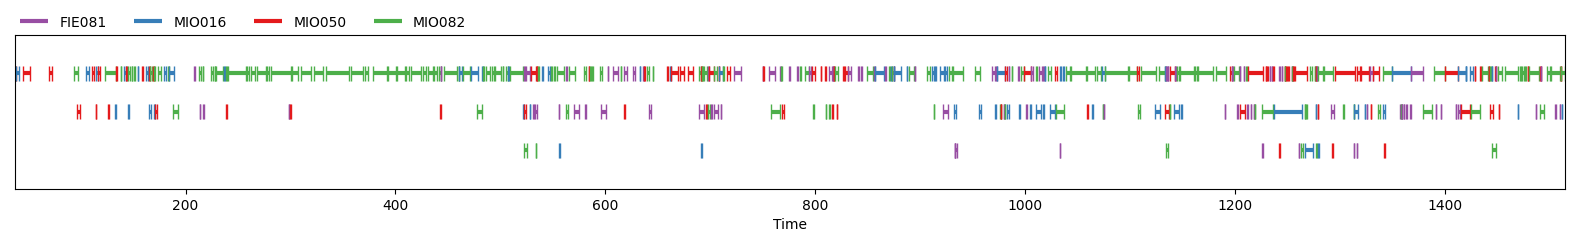

In [3]:
sample = next(dataset.train())
print('\n'.join(sample['annotation'].to_rttm().split('\n')[:10]) + '\n...')
sample['annotation']

In [127]:
from pyannote.audio.utils.preview import listen
from pyannote.core import Segment

sample_segment = Segment(0, 120)
listen(sample, sample_segment)

<a id='metric'></a>
## How to evaluate a speaker diarization pipeline?

The standard metric for speaker diarization problem is the Diarization error rate: <br><br>
$$ DER= \frac{FalseAlarm+MissedDetection+Confusion}{Total} $$

- **False Alarm** - Speech segment predicted where there is no speaker (False positive from VAD model).
- **Missed Detection** - No speech detected where there is a speaker (False negative from VAD model).
- **Confusion** - Speech is in the wrong cluster (error from the clustering model).

![](https://miro.medium.com/v2/resize:fit:4800/format:webp/1*08iCugqS9zesOJ5L0k5sFQ.png)

<a id='theory'></a>
# A Deep Dive into Theory

<a id='structure'></a>
## General pipeline structure

Early approaches for speaker diarization were based on Digital Signal Processing techniques and later on, based on statistical modeling (Hidden Markov Model, Gaussian Mixture, etc). Modern speaker diarization techniques rely on advanced deep learning and neural networks. In the context of unsupervised speaker diarization (which is the most common approach), the pipeline involves several subtasks to detect voice activity and segment audio into speech and non-speech segments and then clustering them according to the speaker. 

Pre-trained models and frameworks can be easily leveraged to perform speaker diarization with low error rates, and modern frameworks like [pyannote](https://github.com/pyannote/pyannote-audio/tree/develop) and [NeMo](https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/asr/speaker_diarization/intro.html) are flexible and can be tuned for many different use cases without having to finetune models. 

Our focus will be on pyannote, although both frameworks have similar solutions.

The typical SD pipeline structure:<br>
![](https://miro.medium.com/v2/resize:fit:4800/format:webp/1*clA5n1kPDuRvm9ztK0-Rpw.png)

- **Voice Activity Detection / Speaker Segmentation:** Segmenting the speech portions into smaller chunks where each chunk is hypothesized to contain speech from only one speaker or several speakers speaking simultaneously.
- **Audio Embedding:** Extracting meaningful features from the different voices using segments from the previous step.
- **Clustering:** Grouping these segments based on the speaker identity, such that all segments belonging to the same speaker are clustered together.

<a id='segmentation'></a>
## Segmentation

Although there are many standard approaches for the simpler version of the task — binary VAD(e.g. [classical ml approaches overview](https://speechprocessingbook.aalto.fi/Recognition/Voice_activity_detection.html), [unsupervised approach](https://www.researchgate.net/publication/255667085_A_simple_but_efficient_real-time_voice_activity_detection_algorithm)), all of them struggle with the case of simultaneously speaking speakers. So, in this case, we need a SOTA approach [presented](https://arxiv.org/pdf/2104.04045.pdf) in pyannote.

Instead of addressing voice activity detection, speaker change detection, and overlapped speech detection as three different tasks, the task is to train an end-to-end speaker segmentation model whose output encompasses the abovementioned sub-tasks. The task is modeled as a multi-label classification problem using permutation-invariant training. 
![](./images/image1.png)
Actual outputs of our model on two 5s excerpts from the conversation between two speakers. 
- Top row shows the reference annotation. 
- Middle row is the audio chunk ingested by the model. 
- Bottom row depicts the raw speaker activations, as returned by the model. <br>

Thanks to permutation-invariant training, notice how the blue speaker corresponds to the orange activation on the left and to the green one on the right.

$ y=\{ y_{1}, \cdots , y_{T} \}$ where $y_{t} \in \{0,1\}^{K_{\max }}$ and $ y_{t}^{k} = 1 $ if speaker $k$ is active at frame $t$ and $ y_{t}^{k} = 1 $ - otherwise. We may arbitrarily sort speakers by chronological order of their first activity but any permutation of the $K_{\max }$ dimensions is a valid representation of the reference segmentation. Therefore, the binary cross entropy loss function $L_{BCE }$ (classically used for such multi-label classification problems) has to be turned into a
permutation-invariant loss function $L$ by running over all possible permutations perm(y) of y over its $K_{\max }$ dimensions: <br>

$$ L(y, \hat{y}) = \min_{perm(y)} L_{BCE }(y, \hat{y})$$

<a id='embeddings'></a>
## Audio Embeddings

This step consists in extracting $K_{w}$ speaker embeddings for each window $w$: exactly one embedding per speaker who is active within the window $w$.
![](./images/image2.png)

Speaker embedding. 
- Top row: 5s audio chunk. 
- Middle row: two speakers are active according to the neural speaker segmentation model (the orange one and the blue one).
- Bottom row: the speaker embedding of the blue speaker is computed using only the blue audio signal, while the concatenation of orange audio signals is used to compute the speaker embedding of the orange speaker. No embedding is extracted for the green speaker as its probability never goes above θ segmentation threshold.

As depicted by they gray overlay, speakers may overlap partially within the considered window. To account for this possibility, the embedding of each speaker is computed from the concatenation of audio samples during which the particular speaker is active and other speakers are inactive. This could be called overlap-aware speaker embeddings.

Compared to the standard approach that consists in extracting exactly one speaker embedding using a short (typically 1 or 2 seconds) periodic window, the proposed speaker embeddings are expected to be more reliable for two main reasons:
- they are extracted from audio excerpts that only contain speech samples from one single speaker while the standard approach may extract speaker embeddings from a mixture of speakers (and non-speech);
- they are extracted from potentially longer audio excerpts (up to 5s in case a speaker speaks during the whole window w) while the standard approach is limited to 1 or 2 seconds.

The main drawback of this approach is that it depends on the upstream speaker segmentation model whose errors could lead to degraded speaker embeddings.

From a practical point of view, almost any available pre-trained embedding can be used in this step.

> **Explore**: Check [simple implementation](https://github.com/RF5/simple-speaker-embedding/tree/master) with [Generalized End-to-End Loss](https://arxiv.org/pdf/1710.10467.pdf) for speaker verification.


> **Explore**: Check [Self Supervised Representations Lecture](https://github.com/VSydorskyy/ucu_audio_processing_course/blob/main/Module_1/Lecture_3/Self_Supervised_Representations.ipynb).

<a id='clustering'></a>
## Clustering

The global agglomerative clustering step consists in clustering the resulting set of speaker embedding in order to assign each local speaker (from 5s segment) to a global cluster. 

Although spectral clustering and variational Bayesian hidden Markov models have been the prefered clustering techniques
in recent speaker diarization literature, the proposed pipeline relies on a classical agglomerative hierarchical clustering with centroid linkage (also known as the UPGMC algorithm). <br>

![](https://scikit-learn.org/stable/_images/sphx_glr_plot_cluster_comparison_001.png)

> **Explore**: Check final clustering + diarization [step](https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/main/asr/speaker_diarization/models.html) in NeMo


![](./images/image3.png)

The final step aims at aggregating the clustered local speaker segmentation into an actual speaker diarization output.
It can be summarized as follows:
1. estimating the instantaneous (i.e. for each frame f) number of speakers Kf , by summing the binary local speaker segmentation and averaging over overlapping windows;
2. estimating the instantaneous score of each cluster by summing the clustered local speaker segmentation over overlapping windows;
3. selecting the Kf clusters with highest instantaneous score and converting from discrete frame indices to the temporal domain;
4. filling within-speaker gaps shorter than a (usually short) predefined duration ∆.

<a id='pyannote'></a>
# Pyannote practice

pyannote.audio is an open-source toolkit written in Python for speaker diarization. Based on PyTorch machine learning framework, it comes with state-of-the-art pretrained models and pipelines, that can be further finetuned to your own data for even better performance.

<a id='framework'></a>
## Framework overview

> **Important**: Before runing following cells, accept conditions of those repos:
> - [PyAnnote Segmentation 3.0](https://huggingface.co/pyannote/segmentation-3.0);
> - [PyAnnote Speaker Dialization 3.1](https://huggingface.co/pyannote/speaker-diarization-3.1).

In [6]:
from huggingface_hub import notebook_login
notebook_login()

In [7]:
import torch
from pyannote.audio import Pipeline

pretrained_pipeline = Pipeline.from_pretrained(
    "pyannote/speaker-diarization-3.1", use_auth_token=True
).to(torch.device('cuda'))

In [8]:
from pyannote.metrics.diarization import DiarizationErrorRate
from tqdm.autonotebook import tqdm

metric = DiarizationErrorRate()

sample = list(dataset.test())[0]
sample["pretrained pipeline"] = pretrained_pipeline(sample)
metric(sample["annotation"], sample["pretrained pipeline"], uem=sample["annotated"])
print(f"The pretrained pipeline reaches a Diarization Error Rate (DER) of {100 * abs(metric):.1f}% on sample.")

The pretrained pipeline reaches a Diarization Error Rate (DER) of 20.4% on sample.


In [9]:
from pyannote.audio.utils.preview import listen
from pyannote.core import Segment

sample_segment = Segment(30, 120)
listen(sample, sample_segment)

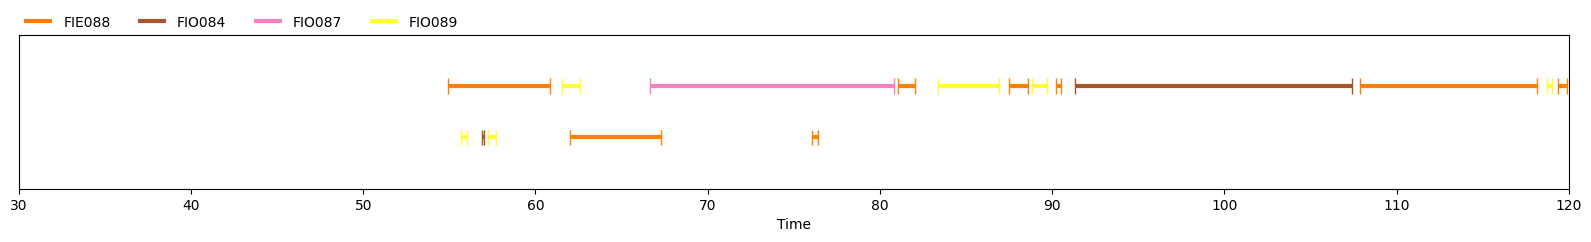

In [10]:
notebook.crop = sample_segment
sample["annotation"]

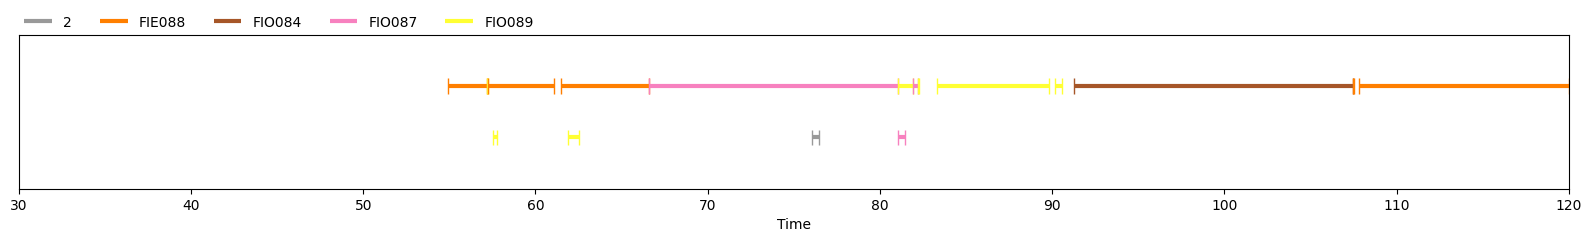

In [11]:
notebook.crop = sample_segment
sample["pretrained pipeline"]

In [12]:
from pyannote.metrics.diarization import DiarizationErrorRate
from tqdm.autonotebook import tqdm

metric = DiarizationErrorRate()

for file in tqdm(dataset.test()):
    file["pretrained pipeline"] = pretrained_pipeline(file)
    metric(file["annotation"], file["pretrained pipeline"], uem=file["annotated"])

print(f"The pretrained pipeline reaches a Diarization Error Rate (DER) of {100 * abs(metric):.1f}% on {dataset.name} test set.")

0it [00:00, ?it/s]

The pretrained pipeline reaches a Diarization Error Rate (DER) of 18.8% on AMI.SpeakerDiarization.only_words test set.


### Pre-trained segmentation component

The first layer of a standard CNN performs a set of time-domain convolutions between the input waveform and some Finite Impulse Response (FIR) filters.

> **Explore**: Check the original SPEAKER RECOGNITION FROM RAW WAVEFORM WITH SINCNET [paper](https://arxiv.org/pdf/1911.01255v1.pdf).

![](./images/image4.png)

In [14]:
from pyannote.audio import Model
model = Model.from_pretrained("pyannote/segmentation-3.0", use_auth_token=True).cuda()
model

PyanNet(
  (sincnet): SincNet(
    (wav_norm1d): InstanceNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (conv1d): ModuleList(
      (0): Encoder(
        (filterbank): ParamSincFB()
      )
      (1): Conv1d(80, 60, kernel_size=(5,), stride=(1,))
      (2): Conv1d(60, 60, kernel_size=(5,), stride=(1,))
    )
    (pool1d): ModuleList(
      (0-2): 3 x MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    )
    (norm1d): ModuleList(
      (0): InstanceNorm1d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (1-2): 2 x InstanceNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    )
  )
  (lstm): LSTM(60, 128, num_layers=4, batch_first=True, dropout=0.5, bidirectional=True)
  (linear): ModuleList(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=128, bias=True)
  )
  (classifier): Linear(in_features=128, out_features=7, bias=

### Pre-trained segmentation component

> **Important**: Before runing following cells, accept conditions of those repos:
> - [PyAnnote Embedding](https://huggingface.co/pyannote/embedding).

In [16]:
model = Model.from_pretrained("pyannote/embedding", use_auth_token=True).cuda()
model

Lightning automatically upgraded your loaded checkpoint from v1.2.7 to v2.2.1. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\Andrii\.cache\torch\pyannote\models--pyannote--embedding\snapshots\c6335d8f1cd77b30084387468a6cf26fea90009b\pytorch_model.bin`
Lightning automatically upgraded your loaded checkpoint from v1.2.7 to v2.2.1. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\Andrii\.cache\torch\pyannote\models--pyannote--embedding\snapshots\c6335d8f1cd77b30084387468a6cf26fea90009b\pytorch_model.bin`


Model was trained with pyannote.audio 0.0.1, yours is 3.1.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.8.1+cu102, yours is 2.2.1+cu118. Bad things might happen unless you revert torch to 1.x.
Model was trained with pyannote.audio 0.0.1, yours is 3.1.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.8.1+cu102, yours is 2.2.1+cu118. Bad things might happen unless you revert torch to 1.x.


XVectorSincNet(
  (sincnet): SincNet(
    (wav_norm1d): InstanceNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (conv1d): ModuleList(
      (0): Encoder(
        (filterbank): ParamSincFB()
      )
      (1): Conv1d(80, 60, kernel_size=(5,), stride=(1,))
      (2): Conv1d(60, 60, kernel_size=(5,), stride=(1,))
    )
    (pool1d): ModuleList(
      (0-2): 3 x MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    )
    (norm1d): ModuleList(
      (0): InstanceNorm1d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (1-2): 2 x InstanceNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    )
  )
  (tdnns): ModuleList(
    (0): Conv1d(60, 512, kernel_size=(5,), stride=(1,))
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv1d(512, 512, kernel_size=(3,), stride=(1,), dilation=(2,))
    (4): Leaky

<a id='finetuning'></a>
## Segmentation finetuning

In [17]:
from pyannote.audio import Model
model = Model.from_pretrained("pyannote/segmentation-3.0", use_auth_token=True).cuda()

In [15]:
from pyannote.audio.tasks import Segmentation
task = Segmentation(
    dataset, 
    duration=model.specifications.duration, 
    max_num_speakers=len(model.specifications.classes), 
    batch_size=32,
    num_workers=8, 
    loss="bce", 
    vad_loss="bce"
)

model.task = task
model.prepare_data()
model.setup()

Protocol AMI.SpeakerDiarization.only_words does not precompute the output of torchaudio.info(): adding a 'torchaudio.info' preprocessor for you to speed up dataloaders. See pyannote.database documentation on how to do that yourself.


In [16]:
from types import MethodType
from torch.optim import Adam
from pytorch_lightning.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    RichProgressBar,
)

# we use Adam optimizer with 1e-4 learning rate
def configure_optimizers(self):
    return Adam(self.parameters(), lr=1e-4)

model.configure_optimizers = MethodType(configure_optimizers, model)

# we monitor diarization error rate on the validation set
# and use to keep the best checkpoint and stop early
monitor, direction = task.val_monitor
checkpoint = ModelCheckpoint(
    monitor=monitor,
    mode=direction,
    save_top_k=1,
    every_n_epochs=1,
    save_last=False,
    save_weights_only=False,
    filename="{epoch}",
    verbose=False,
)
early_stopping = EarlyStopping(
    monitor=monitor,
    mode=direction,
    min_delta=0.0,
    patience=10,
    strict=True,
    verbose=False,
)

callbacks = [RichProgressBar(), checkpoint, early_stopping]

# we train for at most 20 epochs (might be shorter in case of early stopping)
from pytorch_lightning import Trainer
trainer = Trainer(
    accelerator="gpu", 
    callbacks=callbacks, 
    max_epochs=20,
    gradient_clip_val=0.5
)

trainer.fit(model)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   ┃ Name              ┃ Type             ┃ Params ┃       In sizes ┃                                  Out sizes ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ 0 │ sincnet           │ SincNet          │ 42.6 K │ [1, 1, 160000] │                               [1, 60, 589] │
│ 1 │ lstm              │ LSTM             │  1.4 M │   [1, 589, 60] │       [[1, 589, 256], [[8, 1, 128], [8, 1, │
│   │                   │                  │        │                │                                     128]]] │
│ 2 │ linear            │ ModuleList       │ 49.4 K │              ? │                                          ? │
│ 3 │ classifier        │ Linear           │    387 │  [1, 589, 128] │                                [1, 589, 3] │
│ 4 │ activation        │ Sigmoid          │      0 │    [1, 589, 3] │                                [1, 589, 3] │
│ 5 │ validation_metric │ MetricCollection │      0 │              ? │                                          ? │
└───┴───────────────────┴──────────────────┴────────┴────────────────┴────────────────────────────────────────────┘

Trainable params: 1.5 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.5 M                                                                                                
Total estimated model params size (MB): 5

Output()

`Trainer.fit` stopped: `max_epochs=20` reached.


In [17]:
finetuned_model = checkpoint.best_model_path

In [18]:
pretrained_hyperparameters = pretrained_pipeline.parameters(instantiated=True)
pretrained_hyperparameters

{'segmentation': {'min_duration_off': 0.0},
 'clustering': {'method': 'centroid',
  'min_cluster_size': 12,
  'threshold': 0.7045654963945799}}

In [19]:
from pyannote.audio.pipelines import SpeakerDiarization
from pyannote.pipeline import Optimizer

pipeline = SpeakerDiarization(
    segmentation=finetuned_model,
    clustering="OracleClustering",  
).to(torch.device('cuda'))
# as reported in the technical report, min_duration_off can safely be set to 0.0
pipeline.freeze({"segmentation": {"min_duration_off": 0.0}})

optimizer = Optimizer(pipeline)
dev_set = list(dataset.development())

iterations = optimizer.tune_iter(dev_set, show_progress=False)
best_loss = 1.0
for i, iteration in enumerate(iterations):
    print(f"Best segmentation threshold so far: {iteration['params']['segmentation']['threshold']}")
    if i > 20: 
        break   # 50 iterations should give slightly better results

Best segmentation threshold so far: 0.40360409557630705
Best segmentation threshold so far: 0.40360409557630705
Best segmentation threshold so far: 0.5297585542127344
Best segmentation threshold so far: 0.5297585542127344
Best segmentation threshold so far: 0.5297585542127344
Best segmentation threshold so far: 0.5145948817422558
Best segmentation threshold so far: 0.5145948817422558
Best segmentation threshold so far: 0.5145948817422558
Best segmentation threshold so far: 0.5145948817422558
Best segmentation threshold so far: 0.5145948817422558
Best segmentation threshold so far: 0.5145948817422558
Best segmentation threshold so far: 0.5145948817422558
Best segmentation threshold so far: 0.5145948817422558
Best segmentation threshold so far: 0.5145948817422558
Best segmentation threshold so far: 0.5145948817422558
Best segmentation threshold so far: 0.5145948817422558
Best segmentation threshold so far: 0.5145948817422558
Best segmentation threshold so far: 0.5145948817422558
Best seg

In [20]:
optimizer.best_params["segmentation"]["threshold"]

0.5498440816226802

In [21]:
best_segmentation_threshold = optimizer.best_params["segmentation"]["threshold"]
best_segmentation_threshold

0.5498440816226802

In [26]:
pipeline = SpeakerDiarization(
    segmentation=finetuned_model,
    embedding=pretrained_pipeline.embedding,
    embedding_exclude_overlap=pretrained_pipeline.embedding_exclude_overlap,
    clustering=pretrained_pipeline.klustering,
).to(torch.device('cuda'))

pipeline.freeze({
    "segmentation": {
        "threshold": best_segmentation_threshold,
        "min_duration_off": 0.0,
    },
    "clustering": {
        "method": "centroid",
        "min_cluster_size": 15,
    },
})

optimizer = Optimizer(pipeline)
iterations = optimizer.tune_iter(dev_set, show_progress=False)
best_loss = 1.0
for i, iteration in enumerate(iterations):
    print(f"Best clustering threshold so far: {iteration['params']['clustering']['threshold']}")
    if i > 20: break  # 50 iterations should give slightly better results

Best clustering threshold so far: 0.804400784094006
Best clustering threshold so far: 0.804400784094006
Best clustering threshold so far: 0.804400784094006
Best clustering threshold so far: 0.804400784094006
Best clustering threshold so far: 0.804400784094006
Best clustering threshold so far: 0.804400784094006
Best clustering threshold so far: 0.804400784094006
Best clustering threshold so far: 0.804400784094006
Best clustering threshold so far: 0.804400784094006
Best clustering threshold so far: 0.5778640206752805
Best clustering threshold so far: 0.5778640206752805
Best clustering threshold so far: 0.5778640206752805
Best clustering threshold so far: 0.613487348564278
Best clustering threshold so far: 0.613487348564278
Best clustering threshold so far: 0.613487348564278
Best clustering threshold so far: 0.613487348564278
Best clustering threshold so far: 0.613487348564278
Best clustering threshold so far: 0.613487348564278
Best clustering threshold so far: 0.613487348564278
Best clus

In [27]:
best_clustering_threshold = optimizer.best_params['clustering']['threshold']
best_clustering_threshold

0.613487348564278

In [28]:
finetuned_pipeline = SpeakerDiarization(
    segmentation=finetuned_model,
    embedding=pretrained_pipeline.embedding,
    embedding_exclude_overlap=pretrained_pipeline.embedding_exclude_overlap,
    clustering=pretrained_pipeline.klustering,
).to(torch.device('cuda'))

finetuned_pipeline.instantiate({
    "segmentation": {
        "threshold": best_segmentation_threshold,
        "min_duration_off": 0.0,
    },
    "clustering": {
        "method": "centroid",
        "min_cluster_size": 15,
        "threshold": best_clustering_threshold,
    },
})

metric = DiarizationErrorRate()

for file in tqdm(dataset.test()):
    file["finetuned pipeline"] = finetuned_pipeline(file)
    metric(file["annotation"], file["finetuned pipeline"], uem=file["annotated"])

print(f"The finetuned pipeline reaches a Diarization Error Rate (DER) of {100 * abs(metric):.1f}% on {dataset.name} test set.")

0it [00:00, ?it/s]

The finetuned pipeline reaches a Diarization Error Rate (DER) of 17.8% on AMI.SpeakerDiarization.only_words test set.


> **Explore**: Check more pyannote [tutorials](https://github.com/pyannote/pyannote-audio/tree/develop/tutorials) 

<a id='references'></a>
## References

General Overview:
- https://lajavaness.medium.com/speaker-diarization-an-introductory-overview-c070a3bfea70
- https://deepgram.com/learn/what-is-speaker-diarization

Nvidia NeMo:
- https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/main/asr/speaker_diarization/intro.html

pyannote technical report:
- https://huggingface.co/pyannote/speaker-diarization/resolve/main/technical_report_2.1.pdf

Segmentation:
- https://www.researchgate.net/publication/255667085_A_simple_but_efficient_real-time_voice_activity_detection_algorithm
- https://speechprocessingbook.aalto.fi/Recognition/Voice_activity_detection.html
- https://arxiv.org/pdf/2104.04045.pdf

Embeddings: 
- https://github.com/RF5/simple-speaker-embedding/tree/master
- https://arxiv.org/pdf/1710.10467.pdf
- https://arxiv.org/pdf/1911.01255v1.pdf

<a id='homework'></a>
# Homework

**Theory** (5 points):

>Follow **Explore** and **TODO** sections.  
>Answer theory questions in the Google Form.
>List of questions:
> - Could you please describe the key components of the speaker diarization pipeline and indicate which of them could be trainable/fine-tunable (in the exact pipeline discussed in the lecture) and which couldn't?
> - The DER metric is a straightforward and practical way to assess the overall quality of a model. However, it tends to prioritize longer speech segments over shorter ones. This behavior could be problematic as shorter segments may contain crucial linguistic information. Is there a way to tweak our evaluation method to give more weight to shorter segments?
> - Could you propose and describe the design of your pipeline, which would be completely unsupervised in all components? Describe cases when it can work tolerably and when it won't work.
> - Why do we need permutation invariant CE loss modification and cannot use simple CE in the segmentation phase instead?
> - Could you describe the difference between the pyannote and NeMo pipelines in the last stage of clustering/diarization?

**Practice** (10 points):
 
> 1. Check another dataset for training/fine-tuning.
To replace the AMI example dataset with the VoxCeleb dataset, follow these steps:
> - Check the VoxCeleb dataset from a source such as https://mm.kaist.ac.kr/datasets/voxceleb/voxsrc/competition2023.html.
> - You can obtain ready-to-use rttm labeling files from GitHub, such as those found at https://github.com/joonson/voxconverse.
> - Download the corresponding wav files and rttm files.
> - Create a uem file using common sense and modify `AMI-diarization-setup/pyannote/database.yml` with appropriate directories.
> - Finally, finetune the segmentation model from pyannote pipeline. Use dev part for training/validation and test for testing.
> 2. One of the following components should be implemented from scratch (pure pytorch/torchaudio/torchvision/pytorch-lightning) using AMI or VoxCeleb dataset, including proper training, validation, and testing, without relying on frameworks such as pyannote/NeMo:
> - Voice Activity Detection (supervised approach with NN).
> - Segmentation (with permutation invariant CE loss).
> - Audio Embeddings for speaker verification/identification.

In [ ]:
I was unnable to 

# Voice Activity Detection

In [1]:
%cd ../..

E:\UCU\Audio\ucu_audio_processing_course


In [2]:
from pyannote.database import registry, FileFinder

registry.load_database("./AMI-diarization-setup/pyannote/database.yml")
preprocessors = {"audio": FileFinder()}
dataset = registry.get_protocol('AMI.SpeakerDiarization.only_words', preprocessors=preprocessors)

'AMI-SDM.SpeakerDiarization.only_words' found in E:\UCU\Audio\ucu_audio_processing_course\AMI-diarization-setup\pyannote\database.yml does not define the 'scope' of speaker labels (file, database, or global). Setting it to 'file'.
'AMI-SDM.SpeakerDiarization.mini' found in E:\UCU\Audio\ucu_audio_processing_course\AMI-diarization-setup\pyannote\database.yml does not define the 'scope' of speaker labels (file, database, or global). Setting it to 'file'.
'AMI.SpeakerDiarization.only_words' found in E:\UCU\Audio\ucu_audio_processing_course\AMI-diarization-setup\pyannote\database.yml does not define the 'scope' of speaker labels (file, database, or global). Setting it to 'file'.
'AMI.SpeakerDiarization.mini' found in E:\UCU\Audio\ucu_audio_processing_course\AMI-diarization-setup\pyannote\database.yml does not define the 'scope' of speaker labels (file, database, or global). Setting it to 'file'.
'AMI.SpeakerDiarization.word_and_vocalsounds' found in E:\UCU\Audio\ucu_audio_processing_course\

### Extracting segments of speech and silence from all audios in dataset. 

In [3]:
import json
import tqdm

MIN_FRAME_DURATION = 30 # msec

def form_voice_activity_data(dataset, json_path):
    data = {}
    for sample in tqdm.tqdm(dataset):
        try: sample["audio"]
        except FileNotFoundError: continue
        path = str(sample["audio"])
        data[path] = {"speech": [], "silence": []}

        for segment in sample["annotation"].get_timeline().support():
            start, end = segment.start*100, segment.end*100
            if end - start >= MIN_FRAME_DURATION:
                data[path]["speech"].append([start, end])

        speach_start = data[path]["speech"][0][0]
        if speach_start >= MIN_FRAME_DURATION:
            data[path]["silence"].append([0.0, speach_start])

        for segment in sample["annotation"].get_timeline().gaps():
            start, end = segment.start*100, segment.end*100
            if end - start >= MIN_FRAME_DURATION:
                data[path]["silence"].append([start, end])

    with open(json_path, "w") as file:
        json.dump(data, file, indent=4)

In [4]:
form_voice_activity_data(dataset.train(), "train_data.json")

92it [00:05, 12.52it/s]C:\Users\desmo\AppData\Local\Programs\Python\Python39\lib\site-packages\pyannote\database\protocol\protocol.py:140: UserWarning: Existing precomputed key "annotation" has been modified by a preprocessor.
  warnings.warn(msg.format(key=key))
136it [00:09, 14.68it/s]


In [5]:
form_voice_activity_data(dataset.test(), "test_data.json")

16it [00:01, 15.95it/s]


In [10]:
import torch
import torchaudio
import numpy as np
from torch.utils.data import Dataset
import random

### Dataset class.
Given an audio path, returns mel spectrograms of segments with silence and speech. The number of silent and speech segments is the same in every batch. Segments are chosen randomly from audio. From each speech/silence segment, I randomly pick 30 milliseconds of audio, from which the mel spectrograms are calculated.

In [176]:
class SpeechDataset(torch.utils.data.Dataset):
    def __init__(self, data, max_segments=32, sample_rate=16000, n_mels=64):
        self.data = data
        self.max_segments = max_segments
        self.sample_rate = sample_rate
        self.n_mels = n_mels
        self.num_frames = int(MIN_FRAME_DURATION * self.sample_rate / 100)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        filepath = list(self.data.keys())[index]
        
        segments = self.data[filepath]

        speech_segments = segments['speech']
        silence_segments = segments['silence']

        spectrograms = []
        labels = []

        for _ in range(min(len(speech_segments), self.max_segments)):
            segment = random.choice(speech_segments)
            start, end = self.get_random_portion(segment)
            spectrogram = self.calculate_spectrogram(filepath, start, end)
            spectrograms.append(spectrogram)
            labels.append(1)

        for _ in range(min(len(silence_segments), self.max_segments)):
            segment = random.choice(silence_segments)
            start, end = self.get_random_portion(segment)
            spectrogram = self.calculate_spectrogram(filepath, start, end)
            spectrograms.append(spectrogram)
            labels.append(0)
            
        # shuffle the spectrograms and labels together
        combined = list(zip(spectrograms, labels))
        random.shuffle(combined)
        spectrograms, labels = zip(*combined)

        spectrograms = self.normalize(torch.stack(spectrograms))
        labels = torch.tensor(labels).unsqueeze(1)

        return spectrograms, labels

    def get_random_portion(self, segment):
        start, end = segment
        duration = end - start
        if duration <= 30:
            return start, end
        else:
            portion_start = random.uniform(start, end - 30)
            portion_end = portion_start + 30
            return portion_start, portion_end

    def calculate_spectrogram(self, filepath, start, end):
        audio, _ = torchaudio.load(filepath, frame_offset=int(start * self.sample_rate / 100),
                                   num_frames = self.num_frames)
        audio = audio[:1, :]
        spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate=self.sample_rate, n_mels=self.n_mels, )(audio)
        return spectrogram
    
    def normalize(self, spectrograms):
        mean = torch.mean(spectrograms)
        std = torch.std(spectrograms)
        return (spectrograms - mean) / std

In [177]:
with open('train_data.json', 'r') as f:
    data = json.load(f)

train_ratio = 0.8
train_size = int(len(data) * train_ratio)
train_data = dict(list(data.items())[:train_size])
val_data = dict(list(data.items())[train_size:])

train_dataset = SpeechDataset(train_data)
val_dataset = SpeechDataset(val_data)

In [209]:
with open('test_data.json', 'r') as f:
    test_data = json.load(f)
test_dataset = SpeechDataset(test_data)

In [178]:
spectrograms, labels = train_dataset[0]
spectrograms.shape

torch.Size([64, 1, 64, 25])

## Train model

The model is a simple CNN that accepts a spectrogram and predicts one of two classes. This is not a very good approach; I would have needed to implement an autoregressive approach. Unfortunately, I don't have enough time for this, and this simple test approach has proven to be somewhat ok.

In [211]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, shuffle=True)
val_loader = DataLoader(val_dataset)
test_loader = DataLoader(test_dataset)

In [226]:
import torch
import torch.nn as nn
import torch.optim as optim

class VADModel(nn.Module):
    def __init__(self):
        super(VADModel, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(3584 , 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [227]:
from tqdm.notebook import tqdm

def train(epochs, model, optimizer, criterion, train_loader, val_loader, device="cuda"):
    for epoch in tqdm(range(epochs)):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for spectrograms, labels in train_loader:
            spectrograms, labels = spectrograms[0].to(device), labels[0].float().to(device)
            optimizer.zero_grad()
            outputs = model(spectrograms)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * spectrograms.size(1)

        train_loss = train_loss / len(train_loader)

        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for spectrograms, labels in val_loader:
                spectrograms, labels = spectrograms[0].to(device), labels[0].float().to(device)
                outputs = model(spectrograms)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * spectrograms.size(1)
        val_loss = val_loss / len(val_loader)
        
        train_acc = evaluate(model, train_loader)
        val_acc = evaluate(model, val_loader)

        print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc}")
        
        
def evaluate(model, loader, device="cuda"):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for spectrograms, labels in loader:
            spectrograms, labels = spectrograms[0].to(device), labels[0].float().to(device)
            outputs = model(spectrograms)
            acc = (outputs.round() == labels).float().sum()
            total += labels.size(0)
            correct += acc.item()

    accuracy = correct / total
    return accuracy

In [228]:
model = VADModel().to("cuda")

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [229]:
train(40, model, optimizer, criterion, train_loader, val_loader)

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1 | Train Loss: 0.5395 | Train Acc: 0.843473210396399 | Val Loss: 0.3548 | Val Acc: 0.8738839285714286
Epoch 2 | Train Loss: 0.3953 | Train Acc: 0.8469580368810803 | Val Loss: 0.3389 | Val Acc: 0.8839285714285714
Epoch 3 | Train Loss: 0.3786 | Train Acc: 0.8553797008857267 | Val Loss: 0.3295 | Val Acc: 0.8911830357142857
Epoch 4 | Train Loss: 0.3573 | Train Acc: 0.8662697836503558 | Val Loss: 0.3205 | Val Acc: 0.8761160714285714
Epoch 5 | Train Loss: 0.3931 | Train Acc: 0.8667053869609409 | Val Loss: 0.3014 | Val Acc: 0.8761160714285714
Epoch 6 | Train Loss: 0.3593 | Train Acc: 0.8665601858574126 | Val Loss: 0.2875 | Val Acc: 0.8978794642857143
Epoch 7 | Train Loss: 0.3425 | Train Acc: 0.8643821693044867 | Val Loss: 0.2911 | Val Acc: 0.9001116071428571
Epoch 8 | Train Loss: 0.3576 | Train Acc: 0.873529838826775 | Val Loss: 0.3341 | Val Acc: 0.8934151785714286
Epoch 9 | Train Loss: 0.3604 | Train Acc: 0.8770146653114563 | Val Loss: 0.2791 | Val Acc: 0.9006696428571429
Epoch 10 | T

## Evaluation
Accuracy on validation and test sets

In [231]:
evaluate(model, val_loader)

0.9140625

In [235]:
evaluate(model, test_loader)

0.9052734375

Results are not so bad for such a simple model.

## Visualization of prediction

In [329]:
def vad(model, audio, sample_rate):
    model.eval()
    segment_duration = int(MIN_FRAME_DURATION / 100 * sample_rate)
    predictions = np.zeros(int(len(audio)))
    for i in range(len(audio) // segment_duration):
        segment = audio[i*segment_duration : (i + 1)*segment_duration].unsqueeze(0)
        mel_spec = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate, n_mels=64)(segment)
        mel_spec = mel_spec.unsqueeze(1).to("cuda")
        with torch.no_grad():
            predictions[i*segment_duration:(i+1)*segment_duration] = round(model(mel_spec).item())
    return predictions

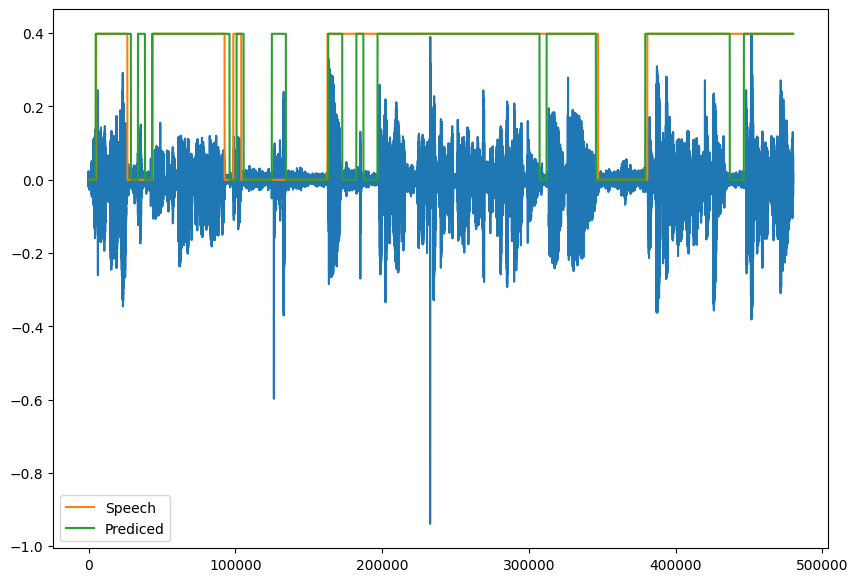

In [333]:
import matplotlib.pyplot as plt
path = 'E:\\UCU\\Audio\\ucu_audio_processing_course\\AMI-diarization-setup\\pyannote\\amicorpus\\IS1009b\\audio\\IS1009b.Mix-Headset.wav'
audio, sr = torchaudio.load(path)

start = 37
length = 30
sample_rate = 16000

audio_start = int(start * sample_rate)
audio = audio[0, audio_start:audio_start + sample_rate*length]
speech_mask = np.zeros(int(len(audio)))
for segment_start, segment_end in test_data[path]["speech"]:
    speech_start = int(segment_start / 100 * sample_rate) - audio_start
    speech_end = int(segment_end / 100 * sample_rate) - audio_start
    speech_mask[speech_start:speech_end] = 1
    
predicted_speech_mask = vad(model, audio, sample_rate)
speech_mask *= audio.max().item()
predicted_speech_mask *= audio.max().item()

plt.figure(figsize=(10, 7))
plt.plot(audio)
plt.plot(speech_mask, label="Speech")
plt.plot(predicted_speech_mask, label="Prediced")
plt.legend()

As we can see, due to the small window size (30 milliseconds), the model can incorrectly predict voice when it's actually silence. Using a larger window and some sort of context (I would try bidirectional LSTM) could possibly improve the model's behavior in such cases.